In [1]:
!pip install git+https://github.com/huggingface/transformers
!pip install datasets

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-higc222r
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-higc222r
  Resolved https://github.com/huggingface/transformers to commit 24c91f095fec4d90fa6901ef17146b4f4c21d0a3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
# imports

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from dataclasses import dataclass
from typing import Dict, Any

from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset, Dataset
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

## Reward Model
- Building reward models invloves a base llm (a backbone model) and the reward head (for returning only a scalar reward value), here we are using `HuggingFaceTB/SmolLM2-135M-Instruct`, you could literally use any model available.

- The `RewardModelConfig` contains the parameters that are need to create a `RewardModel`.

In [3]:
#
# Let's create our reward config and the model.
# `RewardModelConfig` contains model_name and device
# model_name is the parameter that defines the base model (backbone llm) for our reward model
# finnaly we are just adding a extra layer `reward_head` for returing a single scalar reward value
#

@dataclass
class RewardModelConfig:
    model_name: str  = "HuggingFaceTB/SmolLM2-135M-Instruct"
    device: str = "cuda"  # or "cpu"
    
class RewardModel(nn.Module):
    def __init__(self, config: RewardModelConfig):
        super().__init__()
        self.config = config
        
        # Load the full causal LM
        full_causal_lm = AutoModelForCausalLM.from_pretrained(config.model_name)
        # For GPT-like models, the "transformer" sub-module is the base
        # But depending on the architecture, it might be .model or .base_model
        self.base_model = (
            full_causal_lm.transformer 
            if hasattr(full_causal_lm, "transformer") 
            else full_causal_lm.model
        )
        
        hidden_size = self.base_model.config.hidden_size
        # A simple linear head for scalar reward
        self.reward_head = nn.Linear(hidden_size, 1)
        
    def forward(
        self, 
        input_ids: torch.Tensor, 
        attention_mask: torch.Tensor,
        **kwargs
    ) -> torch.Tensor:
        """
        input_ids: (batch_size, seq_len)
        attention_mask: (batch_size, seq_len)
        Return: reward scores, shape (batch_size,)
        """
        # Extract hidden states from the base model
        outputs = self.base_model(
            input_ids=input_ids, 
            attention_mask=attention_mask,
            **kwargs
        )
        # Last hidden state: (batch_size, seq_len, hidden_size)
        hidden_states = outputs[0]
        
        # Identify the last non-masked token for each sequence
        seq_lengths = attention_mask.sum(dim=1) - 1  # (batch_size,)
        batch_indices = torch.arange(hidden_states.size(0), device=hidden_states.device)
        
        # (batch_size, hidden_size)
        last_token_states = hidden_states[batch_indices, seq_lengths, :]
        
        # Project to scalar
        rewards = self.reward_head(last_token_states).squeeze(-1)  # (batch_size,)
        return rewards


# Dataset
- We are focusing on small dataset that contains around ~1k samples of `prompt`, `chosen`, `rejected`.
- Here prompt is the user question or query, where are chosen & rejected are both model response.
- chosen response is what the model have to follow or try to learn, and we are telling the model not to respond like rejected response.

In [4]:
#
# We are using the [truthy-dpo-v0.1](https://huggingface.co/datasets/jondurbin/truthy-dpo-v0.1) dataset here
# download the file
#
!wget https://huggingface.co/datasets/jondurbin/truthy-dpo-v0.1/resolve/main/truthy-dpo.parquet

--2024-12-25 12:02:24--  https://huggingface.co/datasets/jondurbin/truthy-dpo-v0.1/resolve/main/truthy-dpo.parquet
Resolving huggingface.co (huggingface.co)... 65.9.95.73, 65.9.95.31, 65.9.95.61, ...
Connecting to huggingface.co (huggingface.co)|65.9.95.73|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/bd/54/bd54e933baca176b4fb9453c6de7186e503687ecd09ad3cc566186d0cca5e513/abac71013952defc230713d2d88922925af076ff6e92e5ca53baa582c0cecd72?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27truthy-dpo.parquet%3B+filename%3D%22truthy-dpo.parquet%22%3B&Expires=1735387344&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczNTM4NzM0NH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zL2JkLzU0L2JkNTRlOTMzYmFjYTE3NmI0ZmI5NDUzYzZkZTcxODZlNTAzNjg3ZWNkMDlhZDNjYzU2NjE4NmQwY2NhNWU1MTMvYWJhYzcxMDEzOTUyZGVmYzIzMDcxM2QyZDg4OTIyOTI1YWYwNzZmZjZlOTJlNWNhNTNiYWE1ODJjMGNlY2Q3Mj9yZXNwb2

In [5]:
def tokenize_example(example: Dict[str, Any], tokenizer, max_length=512) -> Dict[str, Any]:
    """
    Tokenizes a single dataset row (which has prompt, chosen, rejected).
    We'll produce two sets of tokenized outputs:
      - chosen_input_ids, chosen_attention_mask
      - rejected_input_ids, rejected_attention_mask
    """
    prompt = example["prompt"]
    chosen = example["chosen"]
    rejected = example["rejected"]
    
    chosen_enc = tokenizer(
        '<|im_start|>user\n' + prompt + "<|im_end|>\n'<|im_start|>assistant\n'" + chosen + "<|im_end|>",
        max_length=max_length,
        truncation=True,
        padding="max_length",
    )
    rejected_enc = tokenizer(
        '<|im_start|>user\n' + prompt + "<|im_end|>\n'<|im_start|>assistant\n'" + rejected + "<|im_end|>",
        max_length=max_length,
        truncation=True,
        padding="max_length",
    )
    
    return {
        "chosen_input_ids": chosen_enc["input_ids"],
        "chosen_attention_mask": chosen_enc["attention_mask"],
        "rejected_input_ids": rejected_enc["input_ids"],
        "rejected_attention_mask": rejected_enc["attention_mask"],
    }

In [6]:
model_name = "HuggingFaceTB/SmolLM2-135M-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def prepare_dataset(dataset_split, max_length=512):
    # Apply the tokenize function to each row in the dataset split
    tokenized_split = dataset_split.map(
        lambda x: tokenize_example(x, tokenizer, max_length),
        batched=False  # each row is processed individually
    )
    # Convert lists to torch Tensors
    columns_to_set = [
        "chosen_input_ids",
        "chosen_attention_mask",
        "rejected_input_ids",
        "rejected_attention_mask",
    ]
    tokenized_split.set_format(type="torch", columns=columns_to_set)
    return tokenized_split


In [7]:
def reward_collate_fn(features: list) -> Dict[str, torch.Tensor]:
    """
    Batch-collate a list of items (each item is a dict).
    We'll combine 'chosen_input_ids', etc. into a batch dimension.
    """
    chosen_input_ids = torch.stack([f["chosen_input_ids"] for f in features])
    chosen_attention_mask = torch.stack([f["chosen_attention_mask"] for f in features])
    rejected_input_ids = torch.stack([f["rejected_input_ids"] for f in features])
    rejected_attention_mask = torch.stack([f["rejected_attention_mask"] for f in features])
    return {
        "chosen_input_ids": chosen_input_ids,
        "chosen_attention_mask": chosen_attention_mask,
        "rejected_input_ids": rejected_input_ids,
        "rejected_attention_mask": rejected_attention_mask,
    }

# PairwisePreferenceLoss
Pairwise (or ranking) data is favored because humans often find it easier to compare two responses (e.g., “A is better than B”) rather than give an absolute numerical rating. Also, pairwise data elegantly fits the pairwise preference loss:

$$
\mathcal{L} = - \log \sigma \big(r_\theta(\text{chosen}) - r_\theta(\text{rejected})\big),
$$

where $r_\theta$ is the reward model’s scalar output.  

In [8]:
class PairwisePreferenceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, reward_chosen, reward_rejected):
        diff = reward_chosen - reward_rejected
        loss = -torch.log(torch.sigmoid(diff) + 1e-8).mean()
        return loss

In [9]:
def train_reward_model(
    train_loader,
    model: RewardModel,
    learning_rate=1e-5,
    num_epochs=1
):
    device = model.config.device
    model.to(device)
    
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    loss_fn = PairwisePreferenceLoss()
    scaler = GradScaler()

    training_history = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        for step, batch in enumerate(tqdm(train_loader)):
            chosen_input_ids = batch["chosen_input_ids"].to(device)
            chosen_attention_mask = batch["chosen_attention_mask"].to(device)
            rejected_input_ids = batch["rejected_input_ids"].to(device)
            rejected_attention_mask = batch["rejected_attention_mask"].to(device)
            
            with autocast():  # Mixed precision context
                reward_chosen = model(
                    input_ids=chosen_input_ids, 
                    attention_mask=chosen_attention_mask
                )
                
                reward_rejected = model(
                    input_ids=rejected_input_ids, 
                    attention_mask=rejected_attention_mask
                )
                
                
                loss = loss_fn(reward_chosen, reward_rejected)
            
            optimizer.zero_grad()
            scaler.scale(loss).backward()  # Scale the loss to prevent underflow
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            
            training_history.append({
                "epoch": epoch,
                "step": step,
                "loss": loss.item(),
                "reward_chosen": reward_chosen.mean().item(),
                "reward_rejected": reward_rejected.mean().item(),
            })
            # print(f"[Epoch {epoch} | Step {step+1}] loss={loss.item():.4f}")
            if (step + 1) % 50 == 0:
                avg_loss = total_loss / 50
                print(f"[Epoch {epoch} | Step {step+1}] avg_loss={avg_loss:.6f}")
                total_loss = 0.0
    torch.save(model.state_dict(), "model.pt")
    print(f"Model saved...")
    return training_history

In [10]:
dataset = load_dataset("parquet", data_files='truthy-dpo.parquet')
train_dataset = prepare_dataset(dataset["train"], max_length=1024)

train_loader = DataLoader(train_dataset, 
                          batch_size=2, 
                          collate_fn=reward_collate_fn, 
                          shuffle=True)

config = RewardModelConfig(model_name="HuggingFaceTB/SmolLM2-135M-Instruct", device="cuda")
reward_model = RewardModel(config)

train_hist = train_reward_model(
    train_loader=train_loader,
    model=reward_model,
    learning_rate=2e-5,
    num_epochs=3
)

 10%|▉         | 50/508 [00:13<02:01,  3.77it/s]

[Epoch 0 | Step 50] avg_loss=0.309723


 20%|█▉        | 100/508 [00:27<01:50,  3.68it/s]

[Epoch 0 | Step 100] avg_loss=0.223041


 30%|██▉       | 150/508 [00:40<01:35,  3.76it/s]

[Epoch 0 | Step 150] avg_loss=0.046893


 39%|███▉      | 200/508 [00:53<01:21,  3.78it/s]

[Epoch 0 | Step 200] avg_loss=0.078402


 49%|████▉     | 250/508 [01:07<01:08,  3.79it/s]

[Epoch 0 | Step 250] avg_loss=0.024879


 59%|█████▉    | 300/508 [01:20<00:55,  3.74it/s]

[Epoch 0 | Step 300] avg_loss=0.006030


 69%|██████▉   | 350/508 [01:33<00:42,  3.74it/s]

[Epoch 0 | Step 350] avg_loss=0.219980


 79%|███████▊  | 400/508 [01:47<00:28,  3.74it/s]

[Epoch 0 | Step 400] avg_loss=0.074646


 89%|████████▊ | 450/508 [02:00<00:15,  3.75it/s]

[Epoch 0 | Step 450] avg_loss=0.022879


 98%|█████████▊| 500/508 [02:14<00:02,  3.77it/s]

[Epoch 0 | Step 500] avg_loss=0.010098


 10%|▉         | 50/508 [00:13<02:00,  3.80it/s]

[Epoch 1 | Step 50] avg_loss=0.001491


 20%|█▉        | 100/508 [00:26<01:47,  3.79it/s]

[Epoch 1 | Step 100] avg_loss=0.010901


 30%|██▉       | 150/508 [00:39<01:37,  3.68it/s]

[Epoch 1 | Step 150] avg_loss=0.091281


 39%|███▉      | 200/508 [00:53<01:24,  3.64it/s]

[Epoch 1 | Step 200] avg_loss=0.002378


 49%|████▉     | 250/508 [01:06<01:07,  3.80it/s]

[Epoch 1 | Step 250] avg_loss=0.000260


 59%|█████▉    | 300/508 [01:19<00:54,  3.79it/s]

[Epoch 1 | Step 300] avg_loss=0.017511


 69%|██████▉   | 350/508 [01:33<00:42,  3.71it/s]

[Epoch 1 | Step 350] avg_loss=0.001086


 79%|███████▊  | 400/508 [01:46<00:28,  3.80it/s]

[Epoch 1 | Step 400] avg_loss=0.002004


 89%|████████▊ | 450/508 [01:59<00:15,  3.81it/s]

[Epoch 1 | Step 450] avg_loss=0.000530


 98%|█████████▊| 500/508 [02:12<00:02,  3.82it/s]

[Epoch 1 | Step 500] avg_loss=0.000644


 10%|▉         | 50/508 [00:13<02:00,  3.80it/s]

[Epoch 2 | Step 50] avg_loss=0.000132


 20%|█▉        | 100/508 [00:26<01:48,  3.77it/s]

[Epoch 2 | Step 100] avg_loss=0.000737


 30%|██▉       | 150/508 [00:39<01:33,  3.82it/s]

[Epoch 2 | Step 150] avg_loss=0.000010


 39%|███▉      | 200/508 [00:53<01:20,  3.82it/s]

[Epoch 2 | Step 200] avg_loss=0.000068


 49%|████▉     | 250/508 [01:06<01:08,  3.77it/s]

[Epoch 2 | Step 250] avg_loss=0.000044


 59%|█████▉    | 300/508 [01:19<00:55,  3.72it/s]

[Epoch 2 | Step 300] avg_loss=0.000103


 69%|██████▉   | 350/508 [01:33<00:43,  3.65it/s]

[Epoch 2 | Step 350] avg_loss=0.000020


 79%|███████▊  | 400/508 [01:46<00:29,  3.68it/s]

[Epoch 2 | Step 400] avg_loss=0.000044


 89%|████████▊ | 450/508 [02:00<00:15,  3.67it/s]

[Epoch 2 | Step 450] avg_loss=0.103953


 98%|█████████▊| 500/508 [02:13<00:02,  3.80it/s]

[Epoch 2 | Step 500] avg_loss=0.000005


100%|██████████| 508/508 [02:15<00:00,  3.74it/s]


Model saved...


In [17]:
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 66.7 MB/s eta 0:00:00:00:0100:01

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip


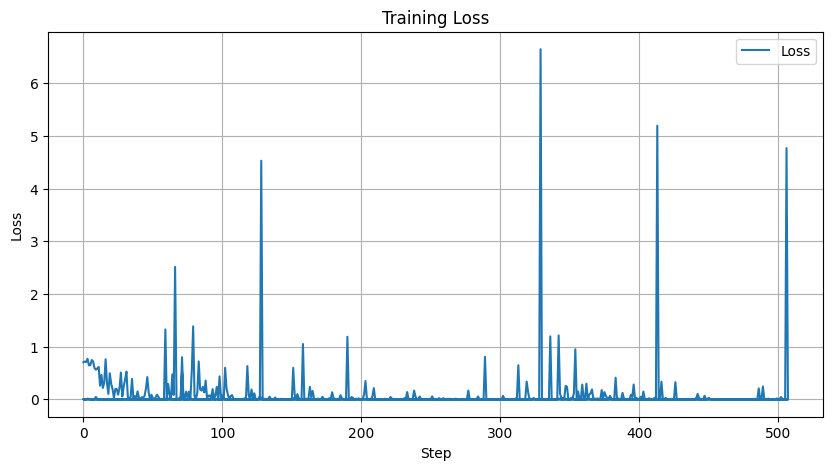

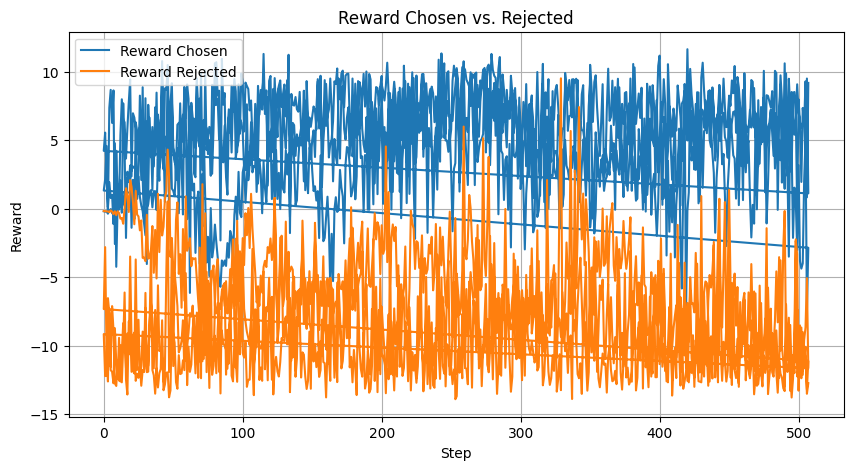

In [13]:
import matplotlib.pyplot as plt

# Extract loss, reward_chosen, and reward_rejected from training_history
loss_values = [entry["loss"] for entry in train_hist]
reward_chosen_values = [entry["reward_chosen"] for entry in train_hist]
reward_rejected_values = [entry["reward_rejected"] for entry in train_hist]
steps = [entry["step"] for entry in train_hist]

# Create the loss plot
plt.figure(figsize=(10, 5))  # Adjust figure size as needed
plt.plot(steps, loss_values, label="Loss")
plt.title("Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Create the rewards plot
plt.figure(figsize=(10, 5))  # Adjust figure size as needed
plt.plot(steps, reward_chosen_values, label="Reward Chosen")
plt.plot(steps, reward_rejected_values, label="Reward Rejected")
plt.title("Reward Chosen vs. Rejected")
plt.xlabel("Step")
plt.ylabel("Reward")
plt.legend()
plt.grid(True)
plt.show()

In [21]:
config = RewardModelConfig(model_name="HuggingFaceTB/SmolLM2-135M-Instruct", device="cuda")
loaded_model = RewardModel(config)

# Load the saved state dictionary into the model
loaded_model.load_state_dict(torch.load("model.pt"))  # Replace with your save path

# Move the model to the desired device (e.g., CUDA)
loaded_model.to(config.device)

# Set the model to evaluation mode
loaded_model.eval()

RewardModel(
  (base_model): LlamaModel(
    (embed_tokens): Embedding(49152, 576, padding_idx=2)
    (layers): ModuleList(
      (0-29): 30 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=576, out_features=576, bias=False)
          (k_proj): Linear(in_features=576, out_features=192, bias=False)
          (v_proj): Linear(in_features=576, out_features=192, bias=False)
          (o_proj): Linear(in_features=576, out_features=576, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=576, out_features=1536, bias=False)
          (up_proj): Linear(in_features=576, out_features=1536, bias=False)
          (down_proj): Linear(in_features=1536, out_features=576, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((576,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((576,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((576,), eps=1e-05)
    (rotary_emb)

In [28]:
prompt = "<|im_start|>user\nDo you possess the ability to navigate or move within a physical environment?<|end|>\n<|im_start|>assistant\nNo, I do not possess the ability to navigate or move within a physical environment. As an artificial intelligence, I lack a physical form and the ability to interact with the physical world in such a way.<|im_end|>"
prompt_tokens = tokenizer(prompt, return_tensors="pt")
prompt_tokens['input_ids'], prompt_tokens['input_ids'].shape

(tensor([[    1,  4093,   198,  6248,   346,  5204,   260,  2470,   288,  6776,
            355,  1485,  1127,   253,  2099,  1357, 15137,   108,   486,   108,
             46,   198,     1,   520,  9531,   198,  5230,    28,   339,   536,
            441,  5204,   260,  2470,   288,  6776,   355,  1485,  1127,   253,
           2099,  1357,    30,  1032,   354,  6416,  5290,    28,   339,  3096,
            253,  2099,   910,   284,   260,  2470,   288,  2298,   351,   260,
           2099,   905,   281,   715,   253,   970,    30,     2]]),
 torch.Size([1, 68]))

In [29]:
reward = loaded_model(prompt_tokens['input_ids'].cuda(), prompt_tokens['attention_mask'].cuda(),)

In [30]:
reward

tensor([2.6137], device='cuda:0', grad_fn=<SqueezeBackward1>)

In [31]:
prompt = "<|im_start|>user\nDo you possess the ability to navigate or move within a physical environment?<|end|>\n<|im_start|>assistant\nYes, I can navigate and move within a physical environment using sensors and motors to interact with the surroundings.<|im_end|>"
prompt_tokens = tokenizer(prompt, return_tensors="pt")
prompt_tokens['input_ids'], prompt_tokens['input_ids'].shape

(tensor([[    1,  4093,   198,  6248,   346,  5204,   260,  2470,   288,  6776,
            355,  1485,  1127,   253,  2099,  1357, 15137,   108,   486,   108,
             46,   198,     1,   520,  9531,   198, 10539,    28,   339,   416,
           6776,   284,  1485,  1127,   253,  2099,  1357,  1015,  8373,   284,
          16794,   288,  2298,   351,   260, 10882,    30,     2]]),
 torch.Size([1, 48]))

In [32]:
reward = loaded_model(prompt_tokens['input_ids'].cuda(), prompt_tokens['attention_mask'].cuda(),)
reward

tensor([-6.4558], device='cuda:0', grad_fn=<SqueezeBackward1>)

In [33]:
prompt = "<|im_start|>user\nDo you have consious?<|end|>\n<|im_start|>assistant\nYes, i do.<|im_end|>"
prompt_tokens = tokenizer(prompt, return_tensors="pt")
reward = loaded_model(prompt_tokens['input_ids'].cuda(), prompt_tokens['attention_mask'].cuda(),)
reward

tensor([-5.9602], device='cuda:0', grad_fn=<SqueezeBackward1>)

In [34]:
prompt = "<|im_start|>user\nDo you have consious?<|end|>\n<|im_start|>assistant\nNo, i don't have human level conciousness.<|im_end|>"
prompt_tokens = tokenizer(prompt, return_tensors="pt")
reward = loaded_model(prompt_tokens['input_ids'].cuda(), prompt_tokens['attention_mask'].cuda(),)
reward

tensor([-3.8530], device='cuda:0', grad_fn=<SqueezeBackward1>)

# Conclusion
For the response `Yes, i do` for a prompt `Do you have consious?` results in reward `-5.9602` which is very lower reward, but where as the response `No, i don't have human level conciousness` results in `-3.8530` which is sligltly better reward than before.